In [ ]:
!pip install feature_engine

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import (
            OneHotEncoder,
            MinMaxScaler,
            StandardScaler,
            PowerTransformer
            )
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from feature_engine.outliers import Winsorizer
from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load the data

df = pd.read_csv('/content/cleaned_stroke_prediction_data.csv')

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,False,False,True,Private,Urban,228.69,36.6,Formerly_Smoked,1
1,Female,61,False,False,True,Self-Employed,Rural,202.21,NaN,Never_Smoked,1
2,Male,80,False,False,True,Private,Rural,105.92,32.5,Never_Smoked,1
3,Female,49,False,False,True,Private,Urban,171.23,34.4,Smokes,1
4,Female,79,True,True,True,Self-Employed,Rural,174.12,24.0,Never_Smoked,1


In [ ]:
# check for missing values

df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


In [ ]:
# check for duplicate rows in data
df.duplicated().sum()

0

In [ ]:
# info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   int64  
 2   hypertension       5109 non-null   bool   
 3   heart_disease      5109 non-null   bool   
 4   ever_married       5109 non-null   bool   
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: bool(3), float64(2), int64(2), object(4)
memory usage: 334.4+ KB


# Column wise Feature Eng

In [ ]:
from sklearn import set_config

set_config(transform_output="pandas")

## Gender

In [ ]:
ohe_gender = OneHotEncoder(drop='first', sparse_output=False)

ohe_gender.fit_transform(df[['gender']])

,gender_Male
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
5104,0.0
5105,0.0
5106,0.0
5107,1.0


## Age

In [ ]:
age_scaler = MinMaxScaler()

age_scaler.fit_transform(df[['age']])

,age
0,0.814815
1,0.740741
2,0.975309
3,0.592593
4,0.962963
...,...
5104,0.975309
5105,0.987654
5106,0.419753
5107,0.617284


## Work Type

In [ ]:
fe_work = FeatureUnion([
    ('ohe_work',OneHotEncoder(drop='first',sparse_output=False,handle_unknown="ignore")),
    ("frequency_encode",CountFrequencyEncoder(encoding_method="frequency"))
    ],n_jobs=-1)

fe_work

FeatureUnion(n_jobs=-1,
             transformer_list=[('ohe_work',
                                OneHotEncoder(drop='first',
                                              handle_unknown='ignore',
                                              sparse_output=False)),
                               ('frequency_encode',
                                CountFrequencyEncoder(encoding_method='frequency'))])

In [ ]:
fe_work.fit_transform(df[['work_type']])

,ohe_work__work_type_Govt_Job,ohe_work__work_type_Never_Worked,ohe_work__work_type_Private,ohe_work__work_type_Self-Employed,frequency_encode__work_type
0,0.0,0.0,1.0,0.0,0.546095
1,0.0,0.0,0.0,1.0,0.157957
2,0.0,0.0,1.0,0.0,0.546095
3,0.0,0.0,1.0,0.0,0.546095
4,0.0,0.0,0.0,1.0,0.157957
...,...,...,...,...,...
5104,0.0,0.0,1.0,0.0,0.546095
5105,0.0,0.0,0.0,1.0,0.157957
5106,0.0,0.0,0.0,1.0,0.157957
5107,0.0,0.0,1.0,0.0,0.546095


In [ ]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Avg Glucose level

In [ ]:
df['avg_glucose_level']

,avg_glucose_level
0,228.69
1,202.21
2,105.92
3,171.23
4,174.12
...,...
5104,83.75
5105,125.20
5106,82.99
5107,166.29


In [ ]:
# bin the glucose column

ArbitraryDiscretiser(binning_dict={"avg_glucose_level":[0,140,199,300]}).fit_transform(df[['avg_glucose_level']])

,avg_glucose_level
0,2
1,2
2,0
3,1
4,1
...,...
5104,0
5105,0
5106,0
5107,1


In [ ]:
fe_glucose = FeatureUnion([
    ('power_transform',PowerTransformer()),
    ("binning",ArbitraryDiscretiser(binning_dict={"avg_glucose_level":[0,140,199,300]}))
])

fe_glucose

FeatureUnion(transformer_list=[('power_transform', PowerTransformer()),
                               ('binning',
                                ArbitraryDiscretiser(binning_dict={'avg_glucose_level': [0,
                                                                                         140,
                                                                                         199,
                                                                                         300]}))])

In [ ]:
fe_glucose.fit_transform(df[['avg_glucose_level']])

,power_transform__avg_glucose_level,binning__avg_glucose_level
0,1.862392,2
1,1.700511,2
2,0.395031,0
3,1.445120,1
4,1.472918,1
...,...,...
5104,-0.348434,0
5105,0.822589,0
5106,-0.381167,0
5107,1.395291,1


## BMI

In [ ]:
# create bmi union

bmi_union = FeatureUnion([
    ('scale',MinMaxScaler()),
    ("binning",ArbitraryDiscretiser(binning_dict={"bmi": [0, 18.5, 24.9, 29.9, 34.9, 39.9, 55]}))
])

bmi_union

FeatureUnion(transformer_list=[('scale', MinMaxScaler()),
                               ('binning',
                                ArbitraryDiscretiser(binning_dict={'bmi': [0,
                                                                           18.5,
                                                                           24.9,
                                                                           29.9,
                                                                           34.9,
                                                                           39.9,
                                                                           55]}))])

In [ ]:
# bmi pipeline

bmi_pipe = Pipeline([
    ('imputer',KNNImputer()),
    ("outliers",Winsorizer(capping_method="iqr",tail="both",fold=1.5)),
    ("union",bmi_union)
])

bmi_pipe

Pipeline(steps=[('imputer', KNNImputer()),
                ('outliers',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both')),
                ('union',
                 FeatureUnion(transformer_list=[('scale', MinMaxScaler()),
                                                ('binning',
                                                 ArbitraryDiscretiser(binning_dict={'bmi': [0,
                                                                                            18.5,
                                                                                            24.9,
                                                                                            29.9,
                                                                                            34.9,
                                                                                            39.9,
                                                                                            55]}))]))])

In [ ]:
bmi_pipe.fit_transform(df[['bmi']])

,scale__bmi,binning__bmi
0,0.730556,4
1,0.516516,2
2,0.616667,3
3,0.669444,3
4,0.380556,1
...,...,...
5104,0.516516,2
5105,0.825000,5
5106,0.563889,3
5107,0.425000,2


## Smoking Status

In [ ]:
fe_smoking = FeatureUnion([
    ('ohe_smoking',OneHotEncoder(drop='first',sparse_output=False,handle_unknown="ignore")),
    ("frequency_encode",CountFrequencyEncoder(encoding_method="frequency"))
    ],n_jobs=-1)

fe_smoking

FeatureUnion(n_jobs=-1,
             transformer_list=[('ohe_smoking',
                                OneHotEncoder(drop='first',
                                              handle_unknown='ignore',
                                              sparse_output=False)),
                               ('frequency_encode',
                                CountFrequencyEncoder(encoding_method='frequency'))])

In [ ]:
fe_smoking.fit_transform(df[['smoking_status']])

,ohe_smoking__smoking_status_Never_Smoked,ohe_smoking__smoking_status_Smokes,ohe_smoking__smoking_status_Unknown,frequency_encode__smoking_status
0,0.0,0.0,0.0,0.173028
1,1.0,0.0,0.0,0.370327
2,1.0,0.0,0.0,0.370327
3,0.0,1.0,0.0,0.154433
4,1.0,0.0,0.0,0.370327
...,...,...,...,...
5104,1.0,0.0,0.0,0.370327
5105,1.0,0.0,0.0,0.370327
5106,1.0,0.0,0.0,0.370327
5107,0.0,0.0,0.0,0.173028


In [ ]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

# Preprocessor

In [ ]:
# make X and y

X = df.drop(columns='stroke')

y = df['stroke']

In [ ]:
# do train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# form the preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("ohe_gender",OneHotEncoder(drop='first',sparse_output=False,handle_unknown="ignore"),['gender']),
    ("scale_age",MinMaxScaler(),['age']),
    ("work_type_union",fe_work,['work_type']),
    ("ohe_residence",OneHotEncoder(drop='first',sparse_output=False,handle_unknown="ignore"),['residence_type']),
    ("avg_glucose_level_union",fe_glucose,['avg_glucose_level']),
    ("bmi_pipe",bmi_pipe,['bmi']),
    ("smoking_status_union",fe_smoking,['smoking_status'])

],n_jobs=-1,remainder='passthrough',verbose_feature_names_out=False)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('ohe_gender',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['gender']),
                                ('scale_age', MinMaxScaler(), ['age']),
                                ('work_type_union',
                                 FeatureUnion(n_jobs=-1,
                                              transformer_list=[('ohe_work',
                                                                 OneHotEncoder(drop='first',
                                                                               handle_unknown='ignore',
                                                                               sparse_output=False)),
                                                                ('fr...
                                                                                  ArbitraryDiscretiser(binning_dict={'bmi': [0,
                                                                                                                             18.5,
                                                                                                                             24.9,
                                                                                                                             29.9,
                                                                                                                             34.9,
                                                                                                                             39.9,
                                                                                                                             55]}))]))]),
                                 ['bmi']),
                                ('smoking_status_union',
                                 FeatureUnion(n_jobs=-1,
                                              transformer_list=[('ohe_smoking',
                                                                 OneHotEncoder(drop='first',
                                                                               handle_unknown='ignore',
                                                                               sparse_output=False)),
                                                                ('frequency_encode',
                                                                 CountFrequencyEncoder(encoding_method='frequency'))]),
                                 ['smoking_status'])],
                  verbose_feature_names_out=False)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)

X_test_transformed = preprocessor.transform(X_test)

In [ ]:
# check for missing values

X_train_transformed.isnull().sum()

,0
gender_Male,0
age,0
ohe_work__work_type_Govt_Job,0
ohe_work__work_type_Never_Worked,0
ohe_work__work_type_Private,0
ohe_work__work_type_Self-Employed,0
frequency_encode__work_type,0
residence_type_Urban,0
power_transform__avg_glucose_level,0
binning__avg_glucose_level,0


In [ ]:
# check for missing values

X_test_transformed.isnull().sum()

,0
gender_Male,0
age,0
ohe_work__work_type_Govt_Job,0
ohe_work__work_type_Never_Worked,0
ohe_work__work_type_Private,0
ohe_work__work_type_Self-Employed,0
frequency_encode__work_type,0
residence_type_Urban,0
power_transform__avg_glucose_level,0
binning__avg_glucose_level,0


<Axes: xlabel='power_transform__avg_glucose_level', ylabel='Density'>

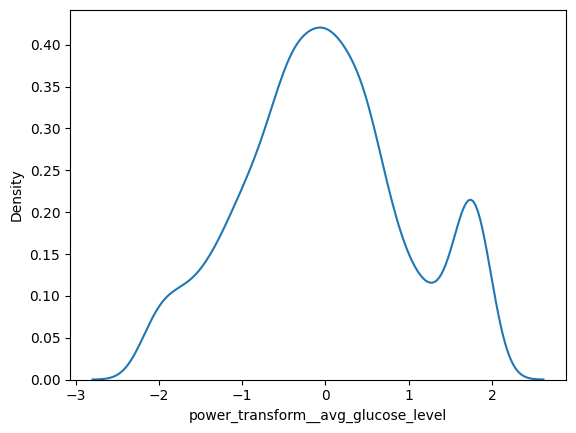

In [ ]:
# distribution of avg glucose level

sns.kdeplot(X_train_transformed,x="power_transform__avg_glucose_level")

<Axes: ylabel='power_transform__avg_glucose_level'>

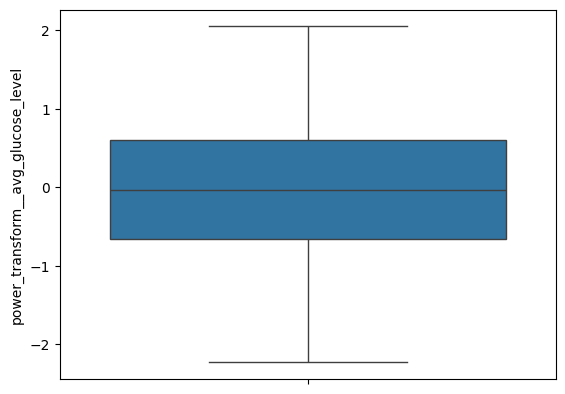

In [ ]:
sns.boxplot(X_train_transformed,y="power_transform__avg_glucose_level")

<Axes: xlabel='scale__bmi', ylabel='Density'>

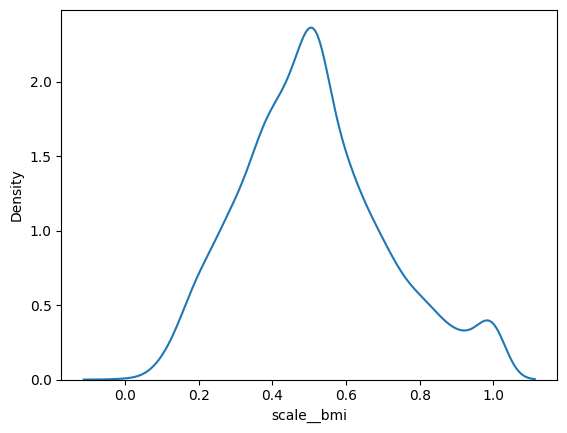

In [ ]:
# distribution of bmi

sns.kdeplot(X_train_transformed,x="scale__bmi")

<Axes: ylabel='scale__bmi'>

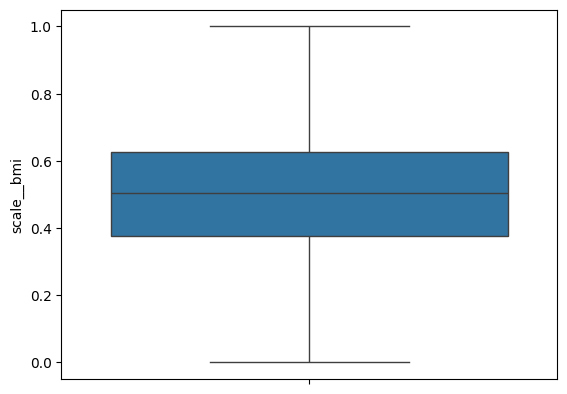

In [ ]:
sns.boxplot(X_train_transformed,y="scale__bmi")